In [ ]:
import numpy as np
#for plotting
import matplotlib.pyplot as plt
#for doing transformations
import cv2
#for path of the file and accessing directories
import os
from torchvision import models
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import copy

In [ ]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
datadir1='/content/drive/My Drive/Deep learning/output_1'
datadir2='/content/drive/My Drive/Deep learning/output_2'
classes=['aeroplane','airport','babble','car','drone','exhibition','helicopter','restaurant','station','street','train']

In [ ]:
from tqdm import tqdm
def create_data(datadir):
  transform=transforms.Compose([transforms.Resize([69,100]),transforms.ToTensor()])
  image_dataset=torchvision.datasets.ImageFolder(root=datadir,transform=transform)
  return image_dataset
data1=create_data(datadir1)
data2=create_data(datadir2)
dataset1=torch.utils.data.DataLoader(data1,batch_size=16,shuffle=True)
dataset2=torch.utils.data.DataLoader(data2,batch_size=16,shuffle=True)

4226
11
torch.Size([3, 69, 100])


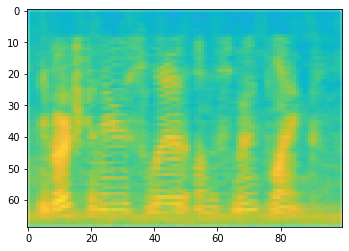

In [ ]:
print(len(data2))
print(len(data1.classes))
print(np.shape(data1.__getitem__(1)[0]))
plt.imshow(np.transpose(data1.__getitem__(1)[0],(1,2,0)))

In [ ]:
data1_train,data1_test=torch.utils.data.random_split(data1,[3800,490],generator=torch.Generator().manual_seed(42))
data2_train,data2_test=torch.utils.data.random_split(data2,[3800,426],generator=torch.Generator().manual_seed(42))

In [ ]:
train_dataset1=torch.utils.data.DataLoader(data1_train,batch_size=16,shuffle=True)
test_dataset1=torch.utils.data.DataLoader(data1_test,batch_size=16,shuffle=False)
train_dataset2=torch.utils.data.DataLoader(data2_train,batch_size=16,shuffle=True)
test_dataset2=torch.utils.data.DataLoader(data2_test,batch_size=16,shuffle=False)

torch.Size([16, 3, 69, 100])
torch.Size([3, 69, 100])
tensor(9)


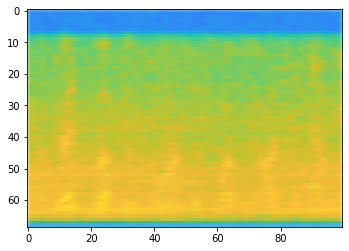

In [ ]:
dataiter=iter(train_dataset1)
images,labels=dataiter.next()
print(images.shape)
print(images[1].shape)
plt.imshow(np.transpose(images[1],(1,2,0)))
print(labels[1])

In [ ]:
def imshow(img,title):
  nimg=img.numpy()
  plt.figure(figsize=(16,1))
  plt.imshow(np.transpose(nimg,(1,2,0)))
  plt.title(title)
  plt.show()


In [ ]:
def batch_images(dataloader1):
  images,labels=next(iter(dataloader1))
  img=torchvision.utils.make_grid(images)
  imshow(img,title=labels)

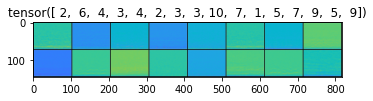

In [ ]:
batch_images(test_dataset2)

In [ ]:
def count_parameters(model):
  print(sum(p.numel() for p in model.parameters() if p.requires_grad))

In [ ]:
batch_size=16
def evaluation(dataloader,model):
    total,correct=0,0
    #model.eval()
    for data in dataloader:
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs)
        _,pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

#Vgg:

In [ ]:
vgg=models.vgg11()

In [ ]:
def count_parameters(model):
  print(sum(p.numel() for p in model.parameters() if p.requires_grad))
count_parameters(vgg)

132863336


In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)

In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=11, bias=True)


In [ ]:
def count_parameters(model):
  print(sum(p.numel() for p in model.parameters() if p.requires_grad))
count_parameters(vgg)

128811403


In [ ]:
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt1=optim.SGD(vgg.parameters(),lr=0.01)

In [ ]:
def evaluation(dataloader,model):
    total,correct=0,0
    #model.eval()
    for data in dataloader:
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs)
        _,pred=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(pred==labels).sum().item()
    return 100*correct/total

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 0/238 ,Loss=2.41
Iteration: 50/238 ,Loss=2.39
Iteration: 100/238 ,Loss=2.39
Iteration: 150/238 ,Loss=2.37
Iteration: 200/238 ,Loss=2.37
Epoch: 0/10 Train_accuracy:13.92 and Test_accuracy:12.45
Iteration: 0/238 ,Loss=2.28
Iteration: 50/238 ,Loss=2.16
Iteration: 100/238 ,Loss=2.31
Iteration: 150/238 ,Loss=2.18
Iteration: 200/238 ,Loss=1.82
Epoch: 1/10 Train_accuracy:19.42 and Test_accuracy:21.02
Iteration: 0/238 ,Loss=2.21
Iteration: 50/238 ,Loss=1.87
Iteration: 100/238 ,Loss=1.72
Iteration: 150/238 ,Loss=1.66
Iteration: 200/238 ,Loss=2.19
Epoch: 2/10 Train_accuracy:48.47 and Test_accuracy:42.86
Iteration: 0/238 ,Loss=1.26
Iteration: 50/238 ,Loss=1.23
Iteration: 100/238 ,Loss=1.37
Iteration: 150/238 ,Loss=0.90
Iteration: 200/238 ,Loss=1.43
Epoch: 3/10 Train_accuracy:66.87 and Test_accuracy:64.90
Iteration: 0/238 ,Loss=0.56
Iteration: 50/238 ,Loss=1.11
Iteration: 100/238 ,Loss=1.00
Iteration: 150/238 ,Loss=1.16
Iteration: 200/238 ,Loss=1.06
Epoch: 4/10 Train_accuracy:72.16 and 

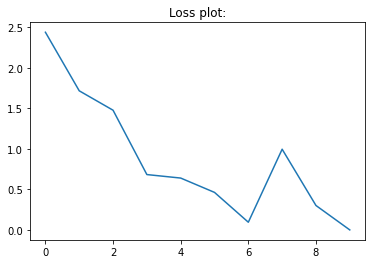

CPU times: user 12min 4s, sys: 2min 5s, total: 14min 10s
Wall time: 36min


In [ ]:
%%time
import copy
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt1.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt1.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,vgg),
                                                                     evaluation(test_dataset1,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()

In [ ]:
%%time
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset1,vgg),'Test data Loss:',evaluation(test_dataset1,vgg))

Training data Loss: 94.52631578947368 Test data Loss: 92.04081632653062
CPU times: user 33.3 s, sys: 7.26 s, total: 40.6 s
Wall time: 43.3 s


In [ ]:
vgg=models.vgg11()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt1=optim.SGD(vgg.parameters(),lr=0.01)

Iteration: 0/238 ,Loss=2.41
Iteration: 50/238 ,Loss=2.38
Iteration: 100/238 ,Loss=2.38
Iteration: 150/238 ,Loss=2.39
Iteration: 200/238 ,Loss=2.37
Epoch: 0/10 Train_accuracy:16.32 and Test_accuracy:16.67
Iteration: 0/238 ,Loss=2.27
Iteration: 50/238 ,Loss=2.43
Iteration: 100/238 ,Loss=2.23
Iteration: 150/238 ,Loss=2.20
Iteration: 200/238 ,Loss=2.02
Epoch: 1/10 Train_accuracy:17.61 and Test_accuracy:17.61
Iteration: 0/238 ,Loss=2.07
Iteration: 50/238 ,Loss=2.52
Iteration: 100/238 ,Loss=2.04
Iteration: 150/238 ,Loss=2.00
Iteration: 200/238 ,Loss=2.11
Epoch: 2/10 Train_accuracy:20.05 and Test_accuracy:19.72
Iteration: 0/238 ,Loss=2.46
Iteration: 50/238 ,Loss=2.04
Iteration: 100/238 ,Loss=2.08
Iteration: 150/238 ,Loss=2.22
Iteration: 200/238 ,Loss=2.01
Epoch: 3/10 Train_accuracy:19.58 and Test_accuracy:18.78
Iteration: 0/238 ,Loss=2.39
Iteration: 50/238 ,Loss=2.16
Iteration: 100/238 ,Loss=2.21
Iteration: 150/238 ,Loss=2.26
Iteration: 200/238 ,Loss=2.37
Epoch: 4/10 Train_accuracy:20.08 and 

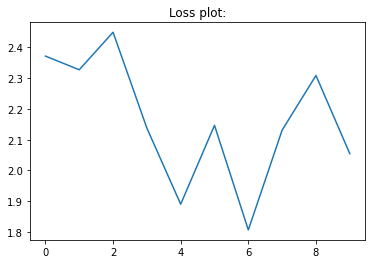

CPU times: user 10min 44s, sys: 48.1 s, total: 11min 32s
Wall time: 33min 23s


In [ ]:
%%time
import copy
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt1.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt1.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,vgg),
                                                                     evaluation(test_dataset2,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()

In [ ]:
%%time
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset2,vgg),'Test data Loss:',evaluation(test_dataset2,vgg))

Training data Loss: 21.36842105263158 Test data Loss: 21.36150234741784
CPU times: user 29.5 s, sys: 1.4 s, total: 30.9 s
Wall time: 33.5 s


#vgg11_bn:

In [ ]:
vgg=models.vgg11_bn()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt12=optim.SGD(vgg.parameters(),lr=0.01)
print(count_parameters(vgg))

128816907
None


Iteration: 0/238 ,Loss=2.68
Iteration: 50/238 ,Loss=1.93
Iteration: 100/238 ,Loss=1.89
Iteration: 150/238 ,Loss=1.24
Iteration: 200/238 ,Loss=1.36
Epoch: 0/10 Train_accuracy:73.71 and Test_accuracy:68.78
Iteration: 0/238 ,Loss=0.41
Iteration: 50/238 ,Loss=0.84
Iteration: 100/238 ,Loss=0.45
Iteration: 150/238 ,Loss=0.58
Iteration: 200/238 ,Loss=0.51
Epoch: 1/10 Train_accuracy:84.97 and Test_accuracy:83.67
Iteration: 0/238 ,Loss=0.28
Iteration: 50/238 ,Loss=0.25
Iteration: 100/238 ,Loss=0.58
Iteration: 150/238 ,Loss=0.07
Iteration: 200/238 ,Loss=0.37
Epoch: 2/10 Train_accuracy:89.32 and Test_accuracy:86.33
Iteration: 0/238 ,Loss=0.61
Iteration: 50/238 ,Loss=0.23
Iteration: 100/238 ,Loss=0.08
Iteration: 150/238 ,Loss=0.11
Iteration: 200/238 ,Loss=0.11
Epoch: 3/10 Train_accuracy:93.16 and Test_accuracy:89.80
Iteration: 0/238 ,Loss=0.33
Iteration: 50/238 ,Loss=0.24
Iteration: 100/238 ,Loss=0.19
Iteration: 150/238 ,Loss=0.36
Iteration: 200/238 ,Loss=0.77
Epoch: 4/10 Train_accuracy:95.08 and 

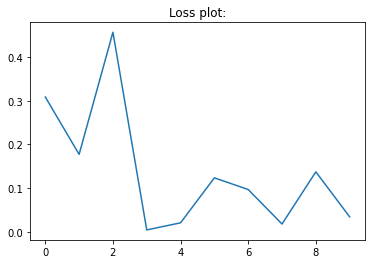

Training data Loss: 97.97368421052632 Test data Loss: 97.14285714285714
CPU times: user 12min 8s, sys: 46.1 s, total: 12min 54s
Wall time: 13min 48s


In [ ]:
%%time
import copy
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt12.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt12.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,vgg),
                                                                     evaluation(test_dataset1,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset1,vgg),'Test data Loss:',evaluation(test_dataset1,vgg))

In [ ]:
vgg=models.vgg11_bn()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt12=optim.SGD(vgg.parameters(),lr=0.01)
print(count_parameters(vgg))

128816907
None


Iteration: 0/238 ,Loss=2.49
Iteration: 50/238 ,Loss=2.30
Iteration: 100/238 ,Loss=2.57
Iteration: 150/238 ,Loss=1.83
Iteration: 200/238 ,Loss=2.21
Epoch: 0/10 Train_accuracy:21.47 and Test_accuracy:21.36
Iteration: 0/238 ,Loss=2.44
Iteration: 50/238 ,Loss=1.89
Iteration: 100/238 ,Loss=1.74
Iteration: 150/238 ,Loss=1.38
Iteration: 200/238 ,Loss=1.24
Epoch: 1/10 Train_accuracy:41.21 and Test_accuracy:41.31
Iteration: 0/238 ,Loss=1.38
Iteration: 50/238 ,Loss=0.52
Iteration: 100/238 ,Loss=0.52
Iteration: 150/238 ,Loss=1.17
Iteration: 200/238 ,Loss=0.55
Epoch: 2/10 Train_accuracy:86.29 and Test_accuracy:84.04
Iteration: 0/238 ,Loss=0.19
Iteration: 50/238 ,Loss=0.71
Iteration: 100/238 ,Loss=0.40
Iteration: 150/238 ,Loss=0.42
Iteration: 200/238 ,Loss=0.36
Epoch: 3/10 Train_accuracy:85.89 and Test_accuracy:83.57
Iteration: 0/238 ,Loss=0.38
Iteration: 50/238 ,Loss=0.30
Iteration: 100/238 ,Loss=0.24
Iteration: 150/238 ,Loss=0.10
Iteration: 200/238 ,Loss=0.45
Epoch: 4/10 Train_accuracy:89.39 and 

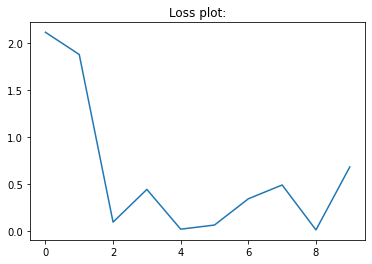

Training data Loss: 95.52631578947368 Test data Loss: 93.1924882629108
CPU times: user 11min 10s, sys: 47.3 s, total: 11min 58s
Wall time: 12min 51s


In [ ]:
%%time
import copy
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt12.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt12.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,vgg),
                                                                     evaluation(test_dataset2,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset2,vgg),'Test data Loss:',evaluation(test_dataset2,vgg))

#vgg16_bn:

134314059
Total number of trainable parameters: None


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 0/238 ,Loss=2.41
Iteration: 50/238 ,Loss=2.52
Iteration: 100/238 ,Loss=1.71
Iteration: 150/238 ,Loss=0.87
Iteration: 200/238 ,Loss=1.34
Epoch: 0/10 Train_accuracy:44.13 and Test_accuracy:41.63
Iteration: 0/238 ,Loss=2.39
Iteration: 50/238 ,Loss=1.44
Iteration: 100/238 ,Loss=0.44
Iteration: 150/238 ,Loss=0.51
Iteration: 200/238 ,Loss=0.50
Epoch: 1/10 Train_accuracy:84.50 and Test_accuracy:81.63
Iteration: 0/238 ,Loss=0.39
Iteration: 50/238 ,Loss=0.10
Iteration: 100/238 ,Loss=0.22
Iteration: 150/238 ,Loss=0.42
Iteration: 200/238 ,Loss=0.39
Epoch: 2/10 Train_accuracy:88.50 and Test_accuracy:83.88
Iteration: 0/238 ,Loss=0.59
Iteration: 50/238 ,Loss=0.31
Iteration: 100/238 ,Loss=0.83
Iteration: 150/238 ,Loss=0.46
Iteration: 200/238 ,Loss=0.13
Epoch: 3/10 Train_accuracy:95.87 and Test_accuracy:93.27
Iteration: 0/238 ,Loss=0.04
Iteration: 50/238 ,Loss=0.08
Iteration: 100/238 ,Loss=0.15
Iteration: 150/238 ,Loss=0.03
Iteration: 200/238 ,Loss=0.24
Epoch: 4/10 Train_accuracy:96.50 and 

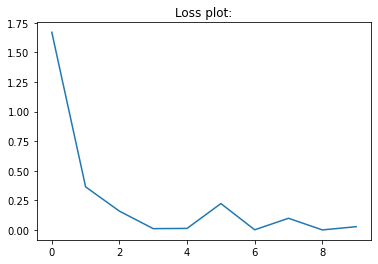

Training data Loss: 99.42105263157895 Test data Loss: 98.36734693877551
CPU times: user 13min 42s, sys: 2min 57s, total: 16min 40s
Wall time: 37min 53s


In [ ]:
%%time
vgg=models.vgg16_bn()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt13=optim.SGD(vgg.parameters(),lr=0.01)
print("Total number of trainable parameters:",count_parameters(vgg))
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt13.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt13.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,vgg),
                                                                     evaluation(test_dataset1,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset1,vgg),'Test data Loss:',evaluation(test_dataset1,vgg))

134314059
Total number of trainable parameters: None
Iteration: 0/238 ,Loss=2.43
Iteration: 50/238 ,Loss=2.10
Iteration: 100/238 ,Loss=2.45
Iteration: 150/238 ,Loss=2.53
Iteration: 200/238 ,Loss=2.09
Epoch: 0/10 Train_accuracy:20.24 and Test_accuracy:17.37
Iteration: 0/238 ,Loss=2.05
Iteration: 50/238 ,Loss=1.99
Iteration: 100/238 ,Loss=1.70
Iteration: 150/238 ,Loss=1.17
Iteration: 200/238 ,Loss=1.11
Epoch: 1/10 Train_accuracy:44.16 and Test_accuracy:43.90
Iteration: 0/238 ,Loss=1.78
Iteration: 50/238 ,Loss=1.30
Iteration: 100/238 ,Loss=0.78
Iteration: 150/238 ,Loss=0.95
Iteration: 200/238 ,Loss=0.61
Epoch: 2/10 Train_accuracy:70.00 and Test_accuracy:66.67
Iteration: 0/238 ,Loss=0.89
Iteration: 50/238 ,Loss=0.62
Iteration: 100/238 ,Loss=0.14
Iteration: 150/238 ,Loss=0.24
Iteration: 200/238 ,Loss=0.36
Epoch: 3/10 Train_accuracy:86.68 and Test_accuracy:86.15
Iteration: 0/238 ,Loss=0.39
Iteration: 50/238 ,Loss=0.26
Iteration: 100/238 ,Loss=0.50
Iteration: 150/238 ,Loss=1.00
Iteration: 200

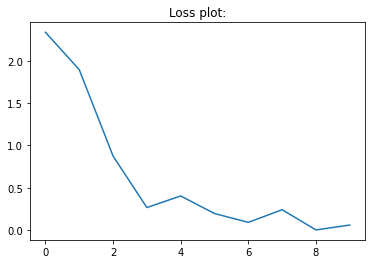

Training data Loss: 95.1842105263158 Test data Loss: 93.42723004694835
CPU times: user 12min 46s, sys: 54 s, total: 13min 40s
Wall time: 34min 9s


In [ ]:
%%time
vgg=models.vgg16_bn()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt13=optim.SGD(vgg.parameters(),lr=0.01)
print("Total number of trainable parameters:",count_parameters(vgg))
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt13.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt13.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,vgg),
                                                                     evaluation(test_dataset2,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset2,vgg),'Test data Loss:',evaluation(test_dataset2,vgg))

#vgg 19_bn:

139626315
Total number of trainable parameters: None
Iteration: 0/238 ,Loss=2.44
Iteration: 50/238 ,Loss=2.03
Iteration: 100/238 ,Loss=1.45
Iteration: 150/238 ,Loss=1.28
Iteration: 200/238 ,Loss=1.21
Epoch: 0/10 Train_accuracy:58.16 and Test_accuracy:57.55
Iteration: 0/238 ,Loss=1.36
Iteration: 50/238 ,Loss=0.22
Iteration: 100/238 ,Loss=0.82
Iteration: 150/238 ,Loss=0.49
Iteration: 200/238 ,Loss=0.54
Epoch: 1/10 Train_accuracy:81.47 and Test_accuracy:78.16
Iteration: 0/238 ,Loss=0.38
Iteration: 50/238 ,Loss=1.09
Iteration: 100/238 ,Loss=0.47
Iteration: 150/238 ,Loss=0.88
Iteration: 200/238 ,Loss=0.76
Epoch: 2/10 Train_accuracy:84.84 and Test_accuracy:81.22
Iteration: 0/238 ,Loss=0.57
Iteration: 50/238 ,Loss=0.14
Iteration: 100/238 ,Loss=0.04
Iteration: 150/238 ,Loss=0.15
Iteration: 200/238 ,Loss=0.13
Epoch: 3/10 Train_accuracy:92.89 and Test_accuracy:90.82
Iteration: 0/238 ,Loss=0.17
Iteration: 50/238 ,Loss=0.23
Iteration: 100/238 ,Loss=0.22
Iteration: 150/238 ,Loss=0.19
Iteration: 200

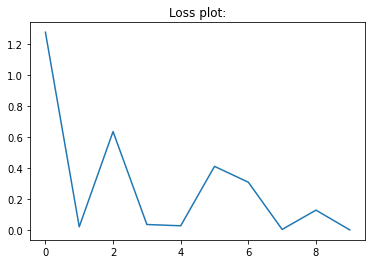

Training data Loss: 98.34210526315789 Test data Loss: 96.3265306122449
CPU times: user 14min 20s, sys: 43 s, total: 15min 3s
Wall time: 27min 32s


In [ ]:
%%time
vgg=models.vgg19_bn()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt14=optim.SGD(vgg.parameters(),lr=0.01)
print("Total number of trainable parameters:",count_parameters(vgg))
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt14.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt14.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,vgg),
                                                                     evaluation(test_dataset1,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset1,vgg),'Test data Loss:',evaluation(test_dataset1,vgg))

139626315
Total number of trainable parameters: None
Iteration: 0/238 ,Loss=2.33
Iteration: 50/238 ,Loss=2.12
Iteration: 100/238 ,Loss=1.83
Iteration: 150/238 ,Loss=2.06
Iteration: 200/238 ,Loss=2.08
Epoch: 0/10 Train_accuracy:17.66 and Test_accuracy:17.14
Iteration: 0/238 ,Loss=2.05
Iteration: 50/238 ,Loss=2.15
Iteration: 100/238 ,Loss=1.85
Iteration: 150/238 ,Loss=2.02
Iteration: 200/238 ,Loss=2.05
Epoch: 1/10 Train_accuracy:19.03 and Test_accuracy:19.95
Iteration: 0/238 ,Loss=1.95
Iteration: 50/238 ,Loss=2.13
Iteration: 100/238 ,Loss=2.25
Iteration: 150/238 ,Loss=1.86
Iteration: 200/238 ,Loss=1.58
Epoch: 2/10 Train_accuracy:34.53 and Test_accuracy:33.10
Iteration: 0/238 ,Loss=2.07
Iteration: 50/238 ,Loss=1.37
Iteration: 100/238 ,Loss=1.25
Iteration: 150/238 ,Loss=1.77
Iteration: 200/238 ,Loss=1.11
Epoch: 3/10 Train_accuracy:54.11 and Test_accuracy:53.99
Iteration: 0/238 ,Loss=1.84
Iteration: 50/238 ,Loss=0.87
Iteration: 100/238 ,Loss=1.48
Iteration: 150/238 ,Loss=1.64
Iteration: 200

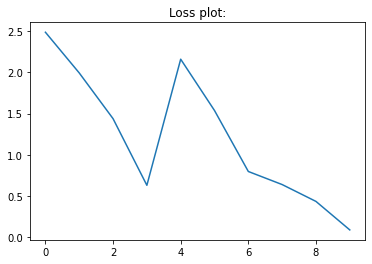

Training data Loss: 93.07894736842105 Test data Loss: 89.90610328638498
CPU times: user 13min 30s, sys: 38.1 s, total: 14min 8s
Wall time: 33min 42s


In [ ]:
%%time
vgg=models.vgg19_bn()
in_features=vgg.classifier[6].in_features
vgg.classifier[6]=nn.Linear(in_features,11)
vgg=vgg.to(device)
loss_fn=nn.CrossEntropyLoss()
opt14=optim.SGD(vgg.parameters(),lr=0.01)
print("Total number of trainable parameters:",count_parameters(vgg))
loss_epoch_error=[]
max_epochs=10
minloss=1000
batch_size=16
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=vgg(inputs)
        opt14.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt14.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_vgg=copy.deepcopy(vgg.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,vgg),
                                                                     evaluation(test_dataset2,vgg)))
    #print('Epoch: %d/%d Train_accuracy:%0.2f'%(epoch,max_epochs,evaluation(trainloader1,vgg)))
                                                                       
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
vgg.load_state_dict(best_model_vgg)
print('Training data Loss:',evaluation(train_dataset2,vgg),'Test data Loss:',evaluation(test_dataset2,vgg))


#resnet18:

In [ ]:
resnet=models.resnet18()

In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)

In [ ]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
print("Total number of trainable parameters:",count_parameters(resnet))
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt21=optim.SGD(resnet.parameters(),lr=0.05)

Iteration: 0/238 ,Loss=2.58
Iteration: 50/238 ,Loss=1.46
Iteration: 100/238 ,Loss=1.26
Iteration: 150/238 ,Loss=0.16
Iteration: 200/238 ,Loss=0.97
Epoch: 0/10 Train_accuracy:65.68 and Test_accuracy:63.67
Iteration: 0/238 ,Loss=0.89
Iteration: 50/238 ,Loss=0.38
Iteration: 100/238 ,Loss=0.38
Iteration: 150/238 ,Loss=0.52
Iteration: 200/238 ,Loss=0.16
Epoch: 1/10 Train_accuracy:90.45 and Test_accuracy:89.80
Iteration: 0/238 ,Loss=0.52
Iteration: 50/238 ,Loss=0.28
Iteration: 100/238 ,Loss=0.08
Iteration: 150/238 ,Loss=0.31
Iteration: 200/238 ,Loss=0.04
Epoch: 2/10 Train_accuracy:89.61 and Test_accuracy:87.76
Iteration: 0/238 ,Loss=0.23
Iteration: 50/238 ,Loss=0.01
Iteration: 100/238 ,Loss=0.02
Iteration: 150/238 ,Loss=0.34
Iteration: 200/238 ,Loss=0.01
Epoch: 3/10 Train_accuracy:91.32 and Test_accuracy:88.57
Iteration: 0/238 ,Loss=0.12
Iteration: 50/238 ,Loss=0.01
Iteration: 100/238 ,Loss=0.05
Iteration: 150/238 ,Loss=0.17
Iteration: 200/238 ,Loss=0.29
Epoch: 4/10 Train_accuracy:92.39 and 

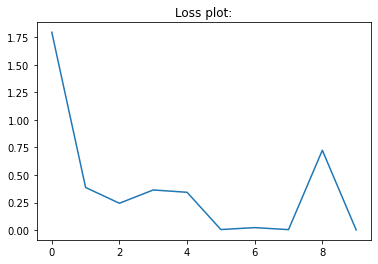

CPU times: user 10min 48s, sys: 27.1 s, total: 11min 15s
Wall time: 34min 46s


In [ ]:
%%time
import copy
batch_size=16
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt21.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt21.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,resnet),
                                                                       evaluation(test_dataset1,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset1,resnet),'Test data Loss:',evaluation(test_dataset1,resnet))

In [ ]:
%%time
resnet=models.resnet18()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt21=optim.SGD(resnet.parameters(),lr=0.05)
print("Total number of trainable parameters:",count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt2.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt2.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,resnet),
                                                                       evaluation(test_dataset2,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset2,resnet),'Test data Loss:',evaluation(test_dataset2,resnet))

#Resnet34

In [ ]:
%%time
resnet=models.resnet34()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt22=optim.SGD(resnet.parameters(),lr=0.05)
print('Number of trainable parameters:',count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt22.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt22.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,resnet),
                                                                       evaluation(test_dataset1,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset1,resnet),'Test data Loss:',evaluation(test_dataset1,resnet))

In [ ]:
%%time
resnet=models.resnet34()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt22=optim.SGD(resnet.parameters(),lr=0.05)
print('Number of trainable parameters:',count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt22.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt22.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,resnet),
                                                                       evaluation(test_dataset2,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset2,resnet),'Test data Loss:',evaluation(test_dataset2,resnet))

#resnet50

In [ ]:
%%time
resnet=models.resnet50()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt23=optim.SGD(resnet.parameters(),lr=0.05)
print('Number of trainable parameters:',count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt23.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt23.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,resnet),
                                                                       evaluation(test_dataset1,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset1,resnet),'Test data Loss:',evaluation(test_dataset1,resnet))

In [ ]:
%%time
resnet=models.resnet50()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt23=optim.SGD(resnet.parameters(),lr=0.05)
print('Number of trainable parameters:',count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt23.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt23.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,resnet),
                                                                       evaluation(test_dataset2,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset2,resnet),'Test data Loss:',evaluation(test_dataset2,resnet))

#Resnet101:

In [ ]:
%%time
resnet=models.resnet101()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt24=optim.SGD(resnet.parameters(),lr=0.05)
print('Number of trainable parameters:',count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt24.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt24.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,resnet),
                                                                       evaluation(test_dataset1,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset1,resnet),'Test data Loss:',evaluation(test_dataset1,resnet))

In [ ]:
%%time
resnet=models.resnet101()
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,11)
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt24=optim.SGD(resnet.parameters(),lr=0.05)
print('Number of trainable parameters:',count_parameters(resnet))
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=resnet(inputs)
        opt24.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt24.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_resnet=copy.deepcopy(resnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,resnet),
                                                                       evaluation(test_dataset2,resnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
resnet.load_state_dict(best_model_resnet)
print('Training data Loss:',evaluation(train_dataset2,resnet),'Test data Loss:',evaluation(test_dataset2,resnet))

#Densenet121:

In [ ]:
densenet=models.densenet121()
in_feature=densenet.classifier.in_features
densenet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(densenet))
densenet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt31=optim.SGD(densenet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=densenet(inputs)
        opt31.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt31.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_densenet=copy.deepcopy(densenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,densenet),
                                                                       evaluation(test_dataset1,densenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
densenet.load_state_dict(best_model_densenet)
print('Training data Loss:',evaluation(train_dataset1,densenet),'Test data Loss:',evaluation(test_dataset1,densenet))

In [ ]:
densenet=models.densenet121()
in_feature=densenet.classifier.in_features
densenet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(densenet))
densenet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt31=optim.SGD(densenet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=densenet(inputs)
        opt31.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt31.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_densenet=copy.deepcopy(densenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,densenet),
                                                                       evaluation(test_dataset2,densenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
densenet.load_state_dict(best_model_densenet)
print('Training data Loss:',evaluation(train_dataset1,densenet),'Test data Loss:',evaluation(test_dataset1,densenet))

#Densenet169:

In [ ]:
%%time
densenet=models.densenet169()
in_feature=densenet.classifier.in_features
densenet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(densenet))
densenet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt32=optim.SGD(densenet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=densenet(inputs)
        opt32.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt32.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_densenet=copy.deepcopy(densenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,densenet),
                                                                       evaluation(test_dataset1,densenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
densenet.load_state_dict(best_model_densenet)
print('Training data Loss:',evaluation(train_dataset1,densenet),'Test data Loss:',evaluation(test_dataset1,densenet))

In [ ]:
%%time
densenet=models.densenet169()
in_feature=densenet.classifier.in_features
densenet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(densenet))
densenet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt32=optim.SGD(densenet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=densenet(inputs)
        opt32.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt32.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_densenet=copy.deepcopy(densenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,densenet),
                                                                       evaluation(test_dataset2,densenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
densenet.load_state_dict(best_model_densenet)
print('Training data Loss:',evaluation(train_dataset2,densenet),'Test data Loss:',evaluation(test_dataset2,densenet))

#Densenet161:

In [ ]:
%%time
densenet=models.densenet161()
in_feature=densenet.classifier.in_features
densenet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(densenet))
densenet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt33=optim.SGD(densenet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=densenet(inputs)
        opt33.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt33.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_densenet=copy.deepcopy(densenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,densenet),
                                                                       evaluation(test_dataset1,densenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
densenet.load_state_dict(best_model_densenet)
print('Training data Loss:',evaluation(train_dataset1,densenet),'Test data Loss:',evaluation(test_dataset1,densenet))

In [ ]:
%%time
densenet=models.densenet161()
in_feature=densenet.classifier.in_features
densenet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(densenet))
densenet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt33=optim.SGD(densenet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=densenet(inputs)
        opt33.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt33.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_densenet=copy.deepcopy(densenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,densenet),
                                                                       evaluation(test_dataset2,densenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
densenet.load_state_dict(best_model_densenet)
print('Training data Loss:',evaluation(train_dataset2,densenet),'Test data Loss:',evaluation(test_dataset2,densenet))

#Alexnet:

In [ ]:
%%time
alexnet=models.alexnet()
in_feature=alexnet.classifier[6].in_features
alexnet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(alexnet))
alexnet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt41=optim.SGD(alexnet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=alexnet(inputs)
        opt41.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt41.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_alexnet=copy.deepcopy(alexnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,alexnet),
                                                                       evaluation(test_dataset1,alexnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
alexnet.load_state_dict(best_model_alexnet)
print('Training data Loss:',evaluation(train_dataset1,alexnet),'Test data Loss:',evaluation(test_dataset1,alexnet))

In [ ]:
%%time
alexnet=models.alexnet()
in_feature=alexnet.classifier[6].in_features
alexnet.classifier=nn.Linear(in_feature,11)
print('Number of trainable parameters:',count_parameters(alexnet))
alexnet=densenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt41=optim.SGD(alexnet.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=alexnet(inputs)
        opt41.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt41.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_alexnet=copy.deepcopy(alexnet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,alexnet),
                                                                       evaluation(test_dataset2,alexnet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
alexnet.load_state_dict(best_model_alexnet)
print('Training data Loss:',evaluation(train_dataset2,alexnet),'Test data Loss:',evaluation(test_dataset2,alexnet))

#Mobilenet:

In [ ]:
mobilenet=models.mobilenet_v2()

In [ ]:
print(mobilenet)

In [ ]:
print(mobilenet)

In [ ]:
in_features=mobilenet.classifier[1].in_features
mobilenet.classifier[1]=nn.Linear(in_features,11)

In [ ]:
mobilenet=mobilenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt5=optim.SGD(mobilenet.parameters(),lr=0.5)

In [ ]:
%%time
import copy
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mobilenet(inputs)
        opt5.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt5.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mobilenet=copy.deepcopy(mobilenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,mobilenet),
                                                                       evaluation(test_dataset1,mobilenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()

In [ ]:
%%time
mobilenet.load_state_dict(best_model_mobilenet)
print('Training data Loss:',evaluation(train_dataset1,mobilenet),'Test data Loss:',evaluation(test_dataset1,mobilenet))

In [ ]:
%%time
import copy
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mobilenet(inputs)
        opt5.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt5.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mobilenet=copy.deepcopy(mobilenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,mobilenet),
                                                                       evaluation(test_dataset2,mobilenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()

In [ ]:
%%time
mobilenet.load_state_dict(best_model_mobilenet)
print('Training data Loss:',evaluation(train_dataset2,mobilenet),'Test data Loss:',evaluation(test_dataset2,mobilenet))

#Googlenet:

In [ ]:
googlenet=models.googlenet()

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [ ]:
googlenet

In [ ]:
in_feature=googlenet.fc.in_features
googlenet.fc=nn.Linear(in_feature,11)
print(googlenet.fc)

Linear(in_features=1024, out_features=11, bias=True)


In [ ]:
googlenet=googlenet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt7=optim.SGD(googlenet.parameters(),lr=0.5)

In [ ]:
%%time
import copy
batch_size=16
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=googlenet(inputs)
        print(outputs)
        print(type(outputs))
        opt7.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt7.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_googlenet=copy.deepcopy(googlenet.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,googlenet),
                                                                       evaluation(test_dataset1,googlenet)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()

GoogLeNetOutputs(logits=tensor([[ 0.3092, -0.4712, -0.0018,  0.0741,  0.1205, -0.2245,  0.0786, -0.1846,
         -0.4536,  0.2169, -0.1752],
        [ 0.5369, -0.2265, -0.1733, -0.0305,  0.0150,  0.1678, -0.4130,  0.2563,
          0.0294,  0.3799, -0.1934],
        [ 0.3935, -0.6157,  0.0416, -0.1831, -0.2549,  0.0198,  0.0713, -0.0017,
         -0.3604,  0.1382, -0.0404],
        [-0.1071, -0.1912,  0.1279, -0.3363,  0.2392,  0.1900,  0.0708, -0.1664,
         -0.0502,  0.1140, -0.1878],
        [ 0.6300, -0.0498, -0.0014, -0.4854,  0.2915,  0.2830,  0.0934, -0.1187,
          0.2513, -0.0896, -0.1739],
        [ 0.2566, -0.4041, -0.2240, -0.1463,  0.1383, -0.1700,  0.3867, -0.1753,
         -0.2208, -0.1056,  0.0594],
        [-0.5706, -0.0056,  0.3378, -0.5382,  0.7116,  0.2470, -0.2875,  0.3214,
         -0.0543,  0.2401, -0.8572],
        [ 0.4747, -0.1748,  0.3433, -0.1275,  0.7133,  0.1989, -0.2929, -0.0690,
         -0.0690,  0.4612,  0.0689],
        [ 0.0581,  0.0064,  0.04

TypeError: ignored

In [ ]:
%%time
#mobilenet.load_state_dict(best_model_googlenet)
print('Training data Loss:',evaluation(train_dataset1,googlenet),'Test data Loss:',evaluation(test_dataset1,googlnet))

AttributeError: ignored

#shufflnet:


In [ ]:
%%time
batch_size=16
sn=models.shufflenet_v2_x0_5()
in_features=sn.fc.in_features
sn.fc=nn.Linear(in_features,11)
count_parameters(sn)
sn=sn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt51=optim.SGD(sn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=sn(inputs)
        opt51.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt51.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_sn=copy.deepcopy(sn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,sn),
                                                                       evaluation(test_dataset1,sn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
sn.load_state_dict(best_model_sn)
print('Training data Loss:',evaluation(train_dataset1,sn),'Test data Loss:',evaluation(test_dataset1,sn))

353067


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 0/238 ,Loss=2.45
Iteration: 50/238 ,Loss=2.24


KeyboardInterrupt: ignored

In [ ]:
a=in_features=sn.fc.in_features
a

1024

In [ ]:
sn

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
mn=models.mobilenet_v3_small()
in_features=mn.classifier[3].in_features
mn.classifier[3]=nn.Linear(in_features,11)

In [ ]:
mn.classifier[3]

Linear(in_features=1024, out_features=11, bias=True)

#resnext(7):

23002443
Iteration: 0/238 ,Loss=2.70
Iteration: 50/238 ,Loss=4.35
Iteration: 100/238 ,Loss=2.14
Iteration: 150/238 ,Loss=1.95
Iteration: 200/238 ,Loss=1.51
Epoch: 0/10 Train_accuracy:51.74 and Test_accuracy:54.08
Iteration: 0/238 ,Loss=1.97
Iteration: 50/238 ,Loss=0.69
Iteration: 100/238 ,Loss=0.70
Iteration: 150/238 ,Loss=1.33
Iteration: 200/238 ,Loss=0.59
Epoch: 1/10 Train_accuracy:80.26 and Test_accuracy:76.33
Iteration: 0/238 ,Loss=0.35
Iteration: 50/238 ,Loss=0.19
Iteration: 100/238 ,Loss=0.64
Iteration: 150/238 ,Loss=0.11
Iteration: 200/238 ,Loss=0.73
Epoch: 2/10 Train_accuracy:83.39 and Test_accuracy:83.47
Iteration: 0/238 ,Loss=0.23
Iteration: 50/238 ,Loss=0.29
Iteration: 100/238 ,Loss=0.27
Iteration: 150/238 ,Loss=1.34
Iteration: 200/238 ,Loss=0.36
Epoch: 3/10 Train_accuracy:83.68 and Test_accuracy:80.41
Iteration: 0/238 ,Loss=0.14
Iteration: 50/238 ,Loss=0.35
Iteration: 100/238 ,Loss=0.02
Iteration: 150/238 ,Loss=0.28
Iteration: 200/238 ,Loss=0.05
Epoch: 4/10 Train_accuracy:9

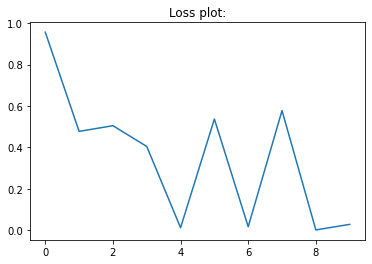

Training data Loss: 98.23684210526316 Test data Loss: 96.93877551020408
CPU times: user 14min 46s, sys: 22.7 s, total: 15min 8s
Wall time: 16min 7s


In [ ]:
%%time
batch_size=16
rn=models.resnext50_32x4d()
in_features=rn.fc.in_features
rn.fc=nn.Linear(in_features,11)
count_parameters(rn)
rn=rn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt71=optim.SGD(rn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=rn(inputs)
        opt71.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt71.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_rn=copy.deepcopy(rn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,rn),
                                                                       evaluation(test_dataset1,rn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
rn.load_state_dict(best_model_rn)
print('Training data Loss:',evaluation(train_dataset1,rn),'Test data Loss:',evaluation(test_dataset1,rn))

23002443
Iteration: 0/238 ,Loss=2.31
Iteration: 50/238 ,Loss=3.63
Iteration: 100/238 ,Loss=2.49
Iteration: 150/238 ,Loss=2.68
Iteration: 200/238 ,Loss=2.57
Epoch: 0/10 Train_accuracy:15.55 and Test_accuracy:13.15
Iteration: 0/238 ,Loss=2.27
Iteration: 50/238 ,Loss=2.47
Iteration: 100/238 ,Loss=2.31
Iteration: 150/238 ,Loss=1.63
Iteration: 200/238 ,Loss=2.61
Epoch: 1/10 Train_accuracy:23.11 and Test_accuracy:22.30
Iteration: 0/238 ,Loss=2.51
Iteration: 50/238 ,Loss=1.82
Iteration: 100/238 ,Loss=1.88
Iteration: 150/238 ,Loss=1.29
Iteration: 200/238 ,Loss=1.22
Epoch: 2/10 Train_accuracy:25.79 and Test_accuracy:22.54
Iteration: 0/238 ,Loss=2.50
Iteration: 50/238 ,Loss=1.24
Iteration: 100/238 ,Loss=1.44
Iteration: 150/238 ,Loss=1.10
Iteration: 200/238 ,Loss=1.09
Epoch: 3/10 Train_accuracy:53.34 and Test_accuracy:53.99
Iteration: 0/238 ,Loss=0.97
Iteration: 50/238 ,Loss=1.73
Iteration: 100/238 ,Loss=1.12
Iteration: 150/238 ,Loss=1.30
Iteration: 200/238 ,Loss=1.02
Epoch: 4/10 Train_accuracy:5

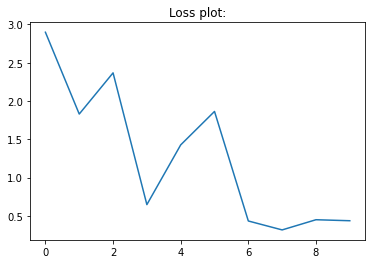

Training data Loss: 91.44736842105263 Test data Loss: 89.67136150234742
CPU times: user 13min 49s, sys: 21.6 s, total: 14min 11s
Wall time: 15min 9s


In [ ]:
%%time
batch_size=16
rn=models.resnext50_32x4d()
in_features=rn.fc.in_features
rn.fc=nn.Linear(in_features,11)
count_parameters(rn)
rn=rn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt71=optim.SGD(rn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=rn(inputs)
        opt71.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt71.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_rn=copy.deepcopy(rn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,rn),
                                                                       evaluation(test_dataset2,rn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
rn.load_state_dict(best_model_rn)
print('Training data Loss:',evaluation(train_dataset2,rn),'Test data Loss:',evaluation(test_dataset2,rn))

#resnext101_32x8d:

86764875


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration: 0/238 ,Loss=2.62
Iteration: 50/238 ,Loss=2.39
Iteration: 100/238 ,Loss=1.53
Iteration: 150/238 ,Loss=1.53
Iteration: 200/238 ,Loss=2.72
Epoch: 0/10 Train_accuracy:51.39 and Test_accuracy:52.65
Iteration: 0/238 ,Loss=1.26
Iteration: 50/238 ,Loss=1.38
Iteration: 100/238 ,Loss=2.61
Iteration: 150/238 ,Loss=0.52
Iteration: 200/238 ,Loss=0.59
Epoch: 1/10 Train_accuracy:76.82 and Test_accuracy:75.31
Iteration: 0/238 ,Loss=0.31
Iteration: 50/238 ,Loss=0.76
Iteration: 100/238 ,Loss=0.85
Iteration: 150/238 ,Loss=0.49
Iteration: 200/238 ,Loss=0.36
Epoch: 2/10 Train_accuracy:87.00 and Test_accuracy:84.49
Iteration: 0/238 ,Loss=0.35
Iteration: 50/238 ,Loss=0.38
Iteration: 100/238 ,Loss=0.55
Iteration: 150/238 ,Loss=0.40
Iteration: 200/238 ,Loss=0.23
Epoch: 3/10 Train_accuracy:84.95 and Test_accuracy:80.20
Iteration: 0/238 ,Loss=1.00
Iteration: 50/238 ,Loss=0.18
Iteration: 100/238 ,Loss=0.23
Iteration: 150/238 ,Loss=0.25
Iteration: 200/238 ,Loss=0.33
Epoch: 4/10 Train_accuracy:81.11 and 

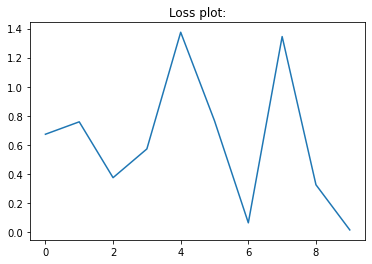

Training data Loss: 94.28947368421052 Test data Loss: 92.04081632653062
CPU times: user 1h 6min 42s, sys: 30min 37s, total: 1h 37min 20s
Wall time: 2h 14min 34s


In [ ]:
%%time
batch_size=16
rn=models.resnext101_32x8d()
in_features=rn.fc.in_features
rn.fc=nn.Linear(in_features,11)
count_parameters(rn)
rn=rn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt72=optim.SGD(rn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=rn(inputs)
        opt72.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt72.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_rn=copy.deepcopy(rn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,rn),
                                                                       evaluation(test_dataset1,rn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
rn.load_state_dict(best_model_rn)
print('Training data Loss:',evaluation(train_dataset1,rn),'Test data Loss:',evaluation(test_dataset1,rn))

In [ ]:
%%time
batch_size=16
rn=models.resnext101_32x8d()
in_features=rn.fc.in_features
rn.fc=nn.Linear(in_features,11)
count_parameters(rn)
rn=rn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt72=optim.SGD(rn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=rn(inputs)
        opt72.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt72.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_rn=copy.deepcopy(rn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,rn),
                                                                       evaluation(test_dataset2,rn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
rn.load_state_dict(best_model_rn)
print('Training data Loss:',evaluation(train_dataset2,rn),'Test data Loss:',evaluation(test_dataset2,rn))

86764875
Iteration: 0/238 ,Loss=2.90
Iteration: 50/238 ,Loss=2.67
Iteration: 100/238 ,Loss=2.32
Iteration: 150/238 ,Loss=2.24
Iteration: 200/238 ,Loss=2.20
Epoch: 0/10 Train_accuracy:10.71 and Test_accuracy:9.62
Iteration: 0/238 ,Loss=2.93
Iteration: 50/238 ,Loss=2.43
Iteration: 100/238 ,Loss=1.75
Iteration: 150/238 ,Loss=2.17
Iteration: 200/238 ,Loss=2.42
Epoch: 1/10 Train_accuracy:23.58 and Test_accuracy:22.77
Iteration: 0/238 ,Loss=2.86
Iteration: 50/238 ,Loss=1.86
Iteration: 100/238 ,Loss=2.37
Iteration: 150/238 ,Loss=1.96
Iteration: 200/238 ,Loss=2.34


#.wide_resnet50_2:

In [ ]:
%%time
batch_size=16
wr=models.wide_resnet50_2()
in_features=wr.fc.in_features
wr.fc=nn.Linear(in_features,11)
count_parameters(wr)
wr=wr.to(device)
loss_fn=nn.CrossEntropyLoss()
opt81=optim.SGD(wr.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=wr(inputs)
        opt81.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt81.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_wr=copy.deepcopy(wr.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,wr),
                                                                       evaluation(test_dataset1,wr)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
wr.load_state_dict(best_model_wr)
print('Training data Loss:',evaluation(train_dataset1,wr),'Test data Loss:',evaluation(test_dataset1,wr))

In [ ]:
%%time
batch_size=16
wr=models.wide_resnet50_2()
in_features=wr.fc.in_features
wr.fc=nn.Linear(in_features,11)
count_parameters(wr)
wr=wr.to(device)
loss_fn=nn.CrossEntropyLoss()
opt81=optim.SGD(wr.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=wr(inputs)
        opt81.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt81.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_wr=copy.deepcopy(wr.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,wr),
                                                                       evaluation(test_dataset2,wr)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
wr.load_state_dict(best_model_wr)
print('Training data Loss:',evaluation(train_dataset2,wr),'Test data Loss:',evaluation(test_dataset2,wr))


#wide_resnet101_2:

In [ ]:
%%time
batch_size=16
wr=models.wide_resnet101_2()
in_features=wr.fc.in_features
wr.fc=nn.Linear(in_features,11)
count_parameters(wr)
wr=wr.to(device)
loss_fn=nn.CrossEntropyLoss()
opt82=optim.SGD(wr.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=wr(inputs)
        opt82.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt82.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_wr=copy.deepcopy(wr.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,wr),
                                                                       evaluation(test_dataset1,wr)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
wr.load_state_dict(best_model_wr)
print('Training data Loss:',evaluation(train_dataset1,wr),'Test data Loss:',evaluation(test_dataset1,wr))

In [ ]:
%%time
batch_size=16
wr=models.wide_resnet101_2()
in_features=wr.fc.in_features
wr.fc=nn.Linear(in_features,11)
count_parameters(wr)
wr=wr.to(device)
loss_fn=nn.CrossEntropyLoss()
opt82=optim.SGD(wr.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=wr(inputs)
        opt82.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt82.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_wr=copy.deepcopy(wr.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,wr),
                                                                       evaluation(test_dataset2,wr)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
wr.load_state_dict(best_model_wr)
print('Training data Loss:',evaluation(train_dataset2,wr),'Test data Loss:',evaluation(test_dataset2,wr))

#mnasnet0_5:

In [ ]:
%%time
mn=models.mnasnet0_5()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt91=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt91.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt91.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,mn),
                                                                       evaluation(test_dataset1,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset1,mn),'Test data Loss:',evaluation(test_dataset1,mn))

In [ ]:
%%time
mn=models.mnasnet0_5()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt91=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt91.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt91.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,mn),
                                                                       evaluation(test_dataset2,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset2,mn),'Test data Loss:',evaluation(test_dataset2,mn))

#mnasnet0_75:

In [ ]:
%%time
mn=models.mnasnet0_75()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt92=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt92.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt92.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,mn),
                                                                       evaluation(test_dataset1,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset1,mn),'Test data Loss:',evaluation(test_dataset1,mn))

In [ ]:
%%time
mn=models.mnasnet0_75()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt92=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt92.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt92.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,mn),
                                                                       evaluation(test_dataset2,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset2,mn),'Test data Loss:',evaluation(test_dataset2,mn))

#mnasnet1_0:

In [ ]:
%%time
mn=models.mnasnet1_0()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt93=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt93.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt93.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,mn),
                                                                       evaluation(test_dataset1,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset1,mn),'Test data Loss:',evaluation(test_dataset1,mn))

In [ ]:
%%time
mn=models.mnasnet1_0()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt93=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt93.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt93.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,mn),
                                                                       evaluation(test_dataset2,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset2,mn),'Test data Loss:',evaluation(test_dataset2,mn))

#mnasnet1_3:

In [ ]:
%%time
mn=models.mnasnet1_3()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt94=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt94.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt94.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,mn),
                                                                       evaluation(test_dataset1,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset1,mn),'Test data Loss:',evaluation(test_dataset1,mn))

In [ ]:
%%time
mn=models.mnasnet1_3()
in_features=mn.classifier[1].in_features
mn.classifier[1]=nn.Linear(in_features,11)
count_parameters(mn)
mn=mn.to(device)
loss_fn=nn.CrossEntropyLoss()
opt94=optim.SGD(mn.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=mn(inputs)
        opt94.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt94.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_mn=copy.deepcopy(mn.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,mn),
                                                                       evaluation(test_dataset2,mn)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
mn.load_state_dict(best_model_mn)
print('Training data Loss:',evaluation(train_dataset2,mn),'Test data Loss:',evaluation(test_dataset2,mn))

#inception_v3:

In [ ]:
%%time
inc=models.inception_v3()
in_features=inc.fc.in_features
inc.fc=nn.Linear(in_features,11)
count_parameters(inc)
inc=inc.to(device)
loss_fn=nn.CrossEntropyLoss()
opt101=optim.SGD(inc.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset1,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=inc(inputs)
        opt101.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt101.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_inc=copy.deepcopy(inc.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset1,inc),
                                                                       evaluation(test_dataset1,inc)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
inc.load_state_dict(best_model_inc)
print('Training data Loss:',evaluation(train_dataset1,inc),'Test data Loss:',evaluation(test_dataset1,inc))

In [ ]:
%%time
inc=models.inception_v3()
in_features=inc.fc.in_features
inc.fc=nn.Linear(in_features,11)
count_parameters(inc)
inc=inc.to(device)
loss_fn=nn.CrossEntropyLoss()
opt101=optim.SGD(inc.parameters(),lr=0.05)
loss_epoch_error=[]
max_epochs=10
minloss=1000
n_iter=np.ceil(3800/batch_size)
for epoch in range(max_epochs):
    for i,data in enumerate(train_dataset2,0):
        inputs,labels=data
        inputs=inputs.float()
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=inc(inputs)
        opt101.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        opt101.step()
        if minloss>loss.item():
          minloss=loss.item()
          best_model_inc=copy.deepcopy(inc.state_dict())
          #print('min loss %0.2f' %minloss)
        if i%50==0:
            print('Iteration: %d/%d ,Loss=%0.2f'%(i,n_iter,loss.item()))
        del inputs,labels,outputs
        torch.cuda.empty_cache()
    loss_epoch_error.append(loss.item())
    print('Epoch: %d/%d Train_accuracy:%0.2f and Test_accuracy:%0.2f'%(epoch,max_epochs,evaluation(train_dataset2,inc),
                                                                       evaluation(test_dataset2,inc)))
plt.plot(loss_epoch_error)
plt.title('Loss plot:')
plt.show()
inc.load_state_dict(best_model_inc)
print('Training data Loss:',evaluation(train_dataset2,inc),'Test data Loss:',evaluation(test_dataset2,inc))